# Google Play Store Data

We will predit the rating of a Google Play Store app as a function of its attributes. We get our data from this source: https://www.kaggle.com/lava18/google-play-store-apps

Our first step will be to import all of the modules we need, and then load the data.

In [1]:
import Pkg
Pkg.add("CSV")
# Pkg.add("Plots")
Pkg.add("DataFrames")
Pkg.add("Statistics")
Pkg.add("StatsPlots")
Pkg.add("Measures")
Pkg.add("LowRankModels")
include("proxgrad.jl")
Pkg.add("Dates")

using Random
Random.seed!(13)

using CSV
# using Plots
using DataFrames
using StatsPlots
using Statistics
using LinearAlgebra
using Measures
using LowRankModels
using Dates

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Pr

In [2]:
apps = CSV.read("googleplaystore.csv", pool=false)
names!(apps, Symbol.(replace.(string.(names(apps)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(apps)
for i in 1:13
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
1	App			String
2	Category			String
3	Rating			Float64
4	Reviews			String
5	Size			String
6	Installs			String
7	Type			String
8	Price			String
9	ContentRating			Union{Missing, String}
10	Genres			String
11	LastUpdated			String
12	CurrentVer			Union{Missing, String}
13	AndroidVer			Union{Missing, String}


In [3]:
apps

10841×13 DataFrame. Omitted printing of 12 columns
│ Row   │ App                                                │
│       │ String                                             │
├───────┼────────────────────────────────────────────────────┤
│ 1     │ Photo Editor & Candy Camera & Grid & ScrapBook     │
│ 2     │ Coloring book moana                                │
│ 3     │ U Launcher Lite – FREE Live Cool Themes, Hide Apps │
│ 4     │ Sketch - Draw & Paint                              │
│ 5     │ Pixel Draw - Number Art Coloring Book              │
│ 6     │ Paper flowers instructions                         │
│ 7     │ Smoke Effect Photo Maker - Smoke Editor            │
│ 8     │ Infinite Painter                                   │
│ 9     │ Garden Coloring Book                               │
│ 10    │ Kids Paint Free - Drawing Fun                      │
⋮
│ 10831 │ News Minecraft.fr                                  │
│ 10832 │ payermonstationnement.fr                           │
│ 10833 │ FR Tides                                           │
│ 10834 │ Chemin (fr)                                        │
│ 10835 │ FR Calculator                                      │
│ 10836 │ FR Forms                                           │
│ 10837 │ Sya9a Maroc - FR                                   │
│ 10838 │ Fr. Mike Schmitz Audio Teachings                   │
│ 10839 │ Parkinson Exercices FR                             │
│ 10840 │ The SCP Foundation DB fr nn5n                      │
│ 10841 │ iHoroscope - 2018 Daily Horoscope & Astrology      │

# (A) Clean Data

In [4]:
#Clean Ratings column 
num_missing=0
for idx=1:size(apps,1)
    if isnan(apps[idx, :Rating])
        num_missing+=1
    end
end 

not_missing_values = []
for idx=1:size(apps,1)
    if !isnan(apps[idx, :Rating])
        push!(not_missing_values, apps[idx, :Rating])
    end
end

mean_not_missing_values = mean(not_missing_values)

println("The mean of the unmissing values is $mean_not_missing_values")
println("We have $num_missing missing rating values")

new_ratings = Union{Missing,Float64}[]
for idx=1:size(apps,1)
    if isnan(apps[idx, :Rating])
        push!(new_ratings, missing)
    else
        push!(new_ratings, apps[idx, :Rating])
    end
end 

apps = select!(apps, Not(:Rating))
insert!(apps, 3, new_ratings, :Rating)
typeof(apps[:, :Rating])

The mean of the unmissing values is 4.193338315362443
We have 1474 missing rating values


Array{Union{Missing, Float64},1}

In [5]:
#Clean Size column

"This function converts strings to floating point values.
Strings that cannot be represented as a number (like NA) are converted to zeros"
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

missing_count = 0 
new_size = Union{Missing,Float64}[]
for idx=1:size(apps,1)
    if rstrip(apps[idx, :Size], 'M') != apps[idx, :Size]
        push!(new_size, string_to_float(rstrip(apps[idx, :Size], 'M')))
    elseif rstrip(apps[idx, :Size], 'k') != apps[idx, :Size]
        push!(new_size, round(string_to_float(rstrip(apps[idx, :Size], 'k'))/1000, digits=1))
    else
        missing_count += 1
        push!(new_size, missing)
    end
end

println("Varies with size count: ", missing_count)

apps = select!(apps, Not(:Size))
insert!(apps, 5, new_size, :Size)
typeof(apps[:, :Size])

Varies with size count: 1696


Array{Union{Missing, Float64},1}

In [6]:
#Clean Installs column

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Installs])
        count += 1 
    end
end 

println(count) 


for idx=1:size(apps,1)
    apps[idx, :Installs] = replace(rstrip(apps[idx, :Installs], '+'), "," => "")
end

print(unique(apps[:, :Installs]))

0
["10000", "500000", "5000000", "50000000", "100000", "50000", "1000000", "10000000", "5000", "100000000", "1000000000", "1000", "500000000", "50", "100", "500", "10", "1", "5", "0", "Free"]

In [7]:
#Clean Type column

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Type])
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Type] == "NaN"
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Type] == "0"
        count += 1 
    end
end 

println(count)

apps = filter(row -> !(row.Type in ["0", "NaN"]), apps);

typeof(apps[:, :Type])

0
1
1


Array{String,1}

In [8]:
print(size(apps))

(10839, 13)

In [9]:
#Clean Content Rating column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :ContentRating])
        count += 1 
    end
end 

println(count)

apps = dropmissing(apps, :ContentRating)

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :ContentRating])
        count += 1 
    end
end 

println(count)


count = 0 
new_content_ratings = String[]
for idx=1:size(apps,1)
    push!(new_content_ratings, apps[idx, :ContentRating])
end 

println(count)

apps = select!(apps, Not(:ContentRating))
insert!(apps, 9, new_content_ratings, :ContentRating)
typeof(apps[:, :ContentRating])

0
0
0


Array{String,1}

In [10]:
#Clean Category column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Category])
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Category] == "1.9"
        count += 1 
    end
end 

print(count)

apps = filter(row -> !(row.Category in ["1.9"]), apps);

0
0

In [11]:
# Clean Price column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Price])
        count += 1 
    end
end 

println(count)

price_float = Float64[]
for i=1:size(apps, 1)
    price = replace(apps[i, :Price], "\$" => "")
    push!(price_float, string_to_float(price))
end

apps = select!(apps, Not(:Price))
insert!(apps, 8, price_float, :Price)
typeof(apps[:, :Price])

0


Array{Float64,1}

In [12]:
# Transform last updated column 

apps = transform(apps, :LastUpdated => ByRow(x -> Dates.Date(x, "U d, y")) => :LastUpdated);
apps = transform(apps, :LastUpdated => ByRow(x -> Dates.datetime2rata(x)) => :LastUpdated);

In [13]:
apps[:, :LastUpdated];

# (B) Imputing Missing Values
First we need to one-hot-encode and many-hot-encode the categorical variables in order to fit a low rank model to the data and impute missing values. 

In [14]:
labels_real = [
    :Reviews,
    :Installs, 
]

vals_real = convert(Matrix, string_to_float.(apps[:, labels_real]))
vals_real = hcat(vals_real, apps[:, :Price])
vals_real = hcat(vals_real, apps[:, :LastUpdated])

#rating_vals = convert(Matrix, apps[:, :Rating])
#vals_real = hcat(vals_real, rating_vals)

10839×4 Array{Float64,2}:
    159.0   10000.0    0.0  736701.0
    967.0  500000.0    0.0  736709.0
  87510.0       5.0e6  0.0  736907.0
 215644.0       5.0e7  0.0  736853.0
    967.0  100000.0    0.0  736865.0
    167.0   50000.0    0.0  736414.0
    178.0   50000.0    0.0  736810.0
  36815.0       1.0e6  0.0  736859.0
  13791.0       1.0e6  0.0  736592.0
    121.0   10000.0    0.0  736878.0
  13880.0       1.0e6  0.0  736629.0
   8788.0       1.0e6  0.0  736906.0
  44829.0       1.0e7  0.0  736786.0
      ⋮                     
    603.0   10000.0    0.0  736134.0
    881.0  100000.0    0.0  735253.0
     38.0    5000.0    0.0  736858.0
   1195.0  100000.0    0.0  735280.0
     44.0    1000.0    0.0  735315.0
      7.0     500.0    0.0  736498.0
      0.0      10.0    0.0  736236.0
     38.0    5000.0    0.0  736535.0
      4.0     100.0    0.0  736881.0
      3.0    1000.0    0.0  736349.0
    114.0    1000.0    0.0  735617.0
 398307.0       1.0e7  0.0  736900.0

In [15]:
# Create one hot encoding for category-type columns 

cat_labels = [
    :Category,
    :Type,
    :ContentRating
]

#Sets of all categories in a particular column
cats_sets = [unique(apps[:, label]) for label in cat_labels]

3-element Array{Array{String,1},1}:
 ["ART_AND_DESIGN", "AUTO_AND_VEHICLES", "BEAUTY", "BOOKS_AND_REFERENCE", "BUSINESS", "COMICS", "COMMUNICATION", "DATING", "EDUCATION", "ENTERTAINMENT"  …  "SPORTS", "TRAVEL_AND_LOCAL", "TOOLS", "PERSONALIZATION", "PRODUCTIVITY", "PARENTING", "WEATHER", "VIDEO_PLAYERS", "NEWS_AND_MAGAZINES", "MAPS_AND_NAVIGATION"]
 ["Free", "Paid"]
 ["Everyone", "Teen", "Everyone 10+", "Mature 17+", "Adults only 18+", "Unrated"]

In [16]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    n = size(column,1) 
    d = size(cats,1) 
    result = zeros(n, d)
    for i = 1:n 
        for j=1:d
            if ismissing(column[i])
                result[i,j]=0
            else
                if column[i] == cats[j] 
                    result[i, j] = 1
                end
            end 
        end
    end
    return result
end

onehot

In [17]:
cat_vals = hcat([onehot(apps[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...); 

In [18]:
split_genres(x) = split(x, ";")

split_genres (generic function with 1 method)

In [19]:
genres = split_genres.(apps[:, :Genres])
genre_types = unique(vcat(genres...))

"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column, cats=unique(col))
    n = size(column, 1)
    d = size(cats, 1)
    result = zeros(n, d)
    
    for i = 1:n
        set_of_descriptions = column[i]
        for j = 1:d 
            if cats[j] in set_of_descriptions
                result[i, j] = 1 
            end
        end
    end 
    result
end

manyhot

In [20]:
genre_vals = manyhot(genres, genre_types)
allvals= hcat(genre_vals, cat_vals, vals_real)

10839×98 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …     159.0   10000.0    0.0  736701.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0        967.0  500000.0    0.0  736709.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0      87510.0       5.0e6  0.0  736907.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0     215644.0       5.0e7  0.0  736853.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0        967.0  100000.0    0.0  736865.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …     167.0   50000.0    0.0  736414.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0        178.0   50000.0    0.0  736810.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0      36815.0       1.0e6  0.0  736859.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0      13791.0       1.0e6  0.0  736592.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0        121.0   10000.0    0.0  736878.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …   13880.0       1.0e6  0.0  736629.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0       8788.0       1.0e6  0.0  736906.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0      44829.0       1.0e7  0.0  736786.

In [21]:
allvals=DataFrame(allvals)
insert!(allvals, 1, apps[:,:Size], :Size)
insert!(allvals, 2, apps[:,:Rating], :Rating)

10839×100 DataFrame. Omitted printing of 94 columns
│ Row   │ Size     │ Rating   │ x1      │ x2      │ x3      │ x4      │
│       │ Float64? │ Float64? │ Float64 │ Float64 │ Float64 │ Float64 │
├───────┼──────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1     │ 19.0     │ 4.1      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 2     │ 14.0     │ 3.9      │ 1.0     │ 1.0     │ 0.0     │ 0.0     │
│ 3     │ 8.7      │ 4.7      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 4     │ 25.0     │ 4.5      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 5     │ 2.8      │ 4.3      │ 1.0     │ 0.0     │ 1.0     │ 0.0     │
│ 6     │ 5.6      │ 4.4      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 7     │ 19.0     │ 3.8      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 8     │ 29.0     │ 4.1      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 9     │ 33.0     │ 4.4      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10    │ 3.1      │ 4.7      │ 1.0     │ 0.0     │ 1.0     │ 0.0     │
⋮
│ 10829 │ 2.3      │ 3.8      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10830 │ 9.8      │ missing  │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10831 │ 0.6      │ 3.8      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10832 │ 0.6      │ 4.8      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10833 │ 2.6      │ 4.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10834 │ 9.6      │ missing  │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10835 │ 53.0     │ 4.5      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10836 │ 3.6      │ 5.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10837 │ 9.5      │ missing  │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10838 │ missing  │ 4.5      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10839 │ 19.0     │ 4.5      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │

In [22]:
k=2

#Fit a general low rank model. This model uses QuadLoss loss for real valued columns, 
#HingeLoss loss for boolean columns, and ordinal HingeLoss loss for integer columns, 
#a small amount of QuadLoss regularization, and scaling and adding an offset to the model.

glrm, labels = GLRM(allvals, k)
X, Y, ch = fit!(glrm)

Fitting GLRM
Iteration 10: objective value = 5.958192967092987e7
Iteration 20: objective value = 2.75814051592878e7
Iteration 30: objective value = 2.7547113235340625e7


([0.5794459631312433 0.5863637623708753 … 0.5845798223770783 0.5822577906086904; 1.0 1.0 … 1.0 1.0], [1.0881209701552332 1.078886066970982 … 0.6039858196537057 1.4360025411108348; 1.8663945129190158 3.11065402890372 … -0.32367934807900506 -1.3838204866220514], ConvergenceHistory("ProxGradGLRM", [Inf, 3.235698656847334e9, 1.6655591111521413e9, 1.0892314317142606e9, 7.117316648624896e8, 4.5909790724887896e8, 2.850931030008717e8, 1.741029540281557e8, 1.1206071081449543e8, 7.466123696060488e7  …  2.757336222534246e7, 2.756976170980984e7, 2.7566421233452763e7, 2.7563058626030758e7, 2.7559695755978085e7, 2.7556378381681576e7, 2.7553070526799124e7, 2.7549925775171123e7, 2.7547113235340625e7, 2.7544844746646438e7], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.362112045288086, 4.051337957382202, 5.635023832321167,

In [23]:
A = impute_missing(glrm)

10839×100 Array{Number,2}:
 19.0      4.1      1.0  0.0  0.0  …     159.0   10000.0    0.0  736701.0
 14.0      3.9      1.0  1.0  0.0        967.0  500000.0    0.0  736709.0
  8.7      4.7      1.0  0.0  0.0      87510.0       5.0e6  0.0  736907.0
 25.0      4.5      1.0  0.0  0.0     215644.0       5.0e7  0.0  736853.0
  2.8      4.3      1.0  0.0  1.0        967.0  100000.0    0.0  736865.0
  5.6      4.4      1.0  0.0  0.0  …     167.0   50000.0    0.0  736414.0
 19.0      3.8      1.0  0.0  0.0        178.0   50000.0    0.0  736810.0
 29.0      4.1      1.0  0.0  0.0      36815.0       1.0e6  0.0  736859.0
 33.0      4.4      1.0  0.0  0.0      13791.0       1.0e6  0.0  736592.0
  3.1      4.7      1.0  0.0  1.0        121.0   10000.0    0.0  736878.0
 28.0      4.4      1.0  0.0  0.0  …   13880.0       1.0e6  0.0  736629.0
 12.0      4.4      1.0  0.0  0.0       8788.0       1.0e6  0.0  736906.0
 20.0      4.2      1.0  0.0  0.0      44829.0       1.0e7  0.0  736786.0
  ⋮        

In [24]:
apps = select!(apps, Not(:Size))
insert!(apps, 1, A[:,1], :Size)
apps = select!(apps, Not(:Rating))
insert!(apps, 1, A[:,2], :Rating)

10839×13 DataFrame. Omitted printing of 11 columns
│ Row   │ Rating  │ Size    │
│       │ Number  │ Number  │
├───────┼─────────┼─────────┤
│ 1     │ 4.1     │ 19.0    │
│ 2     │ 3.9     │ 14.0    │
│ 3     │ 4.7     │ 8.7     │
│ 4     │ 4.5     │ 25.0    │
│ 5     │ 4.3     │ 2.8     │
│ 6     │ 4.4     │ 5.6     │
│ 7     │ 3.8     │ 19.0    │
│ 8     │ 4.1     │ 29.0    │
│ 9     │ 4.4     │ 33.0    │
│ 10    │ 4.7     │ 3.1     │
⋮
│ 10829 │ 3.8     │ 2.3     │
│ 10830 │ 3.72801 │ 9.8     │
│ 10831 │ 3.8     │ 0.6     │
│ 10832 │ 4.8     │ 0.6     │
│ 10833 │ 4.0     │ 2.6     │
│ 10834 │ 3.74517 │ 9.6     │
│ 10835 │ 4.5     │ 53.0    │
│ 10836 │ 5.0     │ 3.6     │
│ 10837 │ 3.72845 │ 9.5     │
│ 10838 │ 4.5     │ 2.50249 │
│ 10839 │ 4.5     │ 19.0    │

In [25]:
print(eltypes(apps))

Type[Number, Number, String, String, String, String, String, Float64, String, String, Int64, Union{Missing, String}, Union{Missing, String}]

In [26]:
print(names(apps))

["Rating", "Size", "App", "Category", "Reviews", "Installs", "Type", "Price", "ContentRating", "Genres", "LastUpdated", "CurrentVer", "AndroidVer"]

In [27]:
size_apps = convert(Array{Float64}, apps[:, :Size]);
print(typeof(size_apps))

apps = select!(apps, Not(:Size))
insert!(apps, 2, size_apps, :Size)
typeof(apps[:, :Size])

Array{Float64,1}

Array{Float64,1}

# (C) Train/Test Split

To make the 80 / 20 train test split, we are going to shuffle the data, and then select the first 80%
  as the train data, with 20%
  held out for validation.

In [194]:
feature_names = names(apps)

apps = apps[shuffle(1:end), :] # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = size(apps, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))
ntest = n-ntrain

target = convert(Array{Float64}, apps[:, :Rating])
data = apps[:, filter(col -> (col != :Rating), feature_names)]

# the following variable records the features of examples in the training set
train_x = data[1:ntrain,:]
# the following variable records the features of examples in the test set
test_x = data[ntrain+1:n,:]
# the following variable records the labels of examples in the training set
train_y = target[1:ntrain,1]
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1:n,1]

Size of dataset: 10839


2168-element Array{Float64,1}:
 4.2
 4.6
 4.1
 4.4
 4.0
 4.4
 2.6
 4.4
 4.5
 5.0
 3.7370656065993213
 4.1
 3.7310376468144244
 ⋮
 3.7350813114120447
 4.5
 4.1
 4.7
 4.2
 3.6
 3.8
 4.5
 4.9
 4.4
 4.2
 4.5

In [195]:
labels_real = [
    :Reviews,
    :Installs,
]

2-element Array{Symbol,1}:
 :Reviews
 :Installs

In [196]:
train_vals_real = convert(Matrix, string_to_float.(train_x[:, labels_real]))
test_vals_real = convert(Matrix, string_to_float.(test_x[:, labels_real]))

# Size, LastUpdated and Price do not have to be converted to float again
train_vals_real = hcat(train_vals_real, train_x[:, :Size])
test_vals_real = hcat(test_vals_real, test_x[:, :Size])

train_vals_real = hcat(train_vals_real, train_x[:, :LastUpdated])
test_vals_real = hcat(test_vals_real, test_x[:, :LastUpdated])

train_vals_real = hcat(train_vals_real, train_x[:, :Price])
test_vals_real = hcat(test_vals_real, test_x[:, :Price])

train_vals_real = hcat(train_vals_real, ones(ntrain, 1))
test_vals_real = hcat(test_vals_real, ones(ntest, 1))

2168×6 Array{Float64,2}:
 155234.0             1.0e6  22.0      736907.0  0.0   1.0
   4011.0        500000.0     2.6      736876.0  0.0   1.0
  14491.0             1.0e6   4.3      736751.0  0.0   1.0
 503757.0             1.0e7   2.48958  736908.0  0.0   1.0
     50.0          5000.0    15.0      736878.0  0.0   1.0
 708710.0             1.0e7   2.50466  736887.0  0.0   1.0
    219.0         50000.0     1.8      735901.0  0.0   1.0
 102215.0             1.0e6  42.0      736870.0  0.0   1.0
    153.0         10000.0     2.48927  736909.0  0.0   1.0
      4.0           100.0    14.0      736884.0  0.0   1.0
      0.0           100.0    21.0      736752.0  0.0   1.0
  26871.0             5.0e6   2.48447  736901.0  0.0   1.0
      0.0            10.0     2.4      736760.0  0.0   1.0
      ⋮                                                ⋮
      0.0             1.0    32.0      736775.0  0.0   1.0
  34126.0             1.0e7   2.49044  736888.0  0.0   1.0
     75.0         10000.0    11.0

In [197]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    return mean((y .- pred) .^ 2)
end

MSE

In [198]:
"""This function plots the main diagonal;
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

plotDiagonal

In [199]:
"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname, title; margin=0.05, plotDiag=true, zeromin=false)
    theme(:default)
    scatter(x,y, label="data", title=title, legend=:topleft)
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
#     if zeromin
#         ylims!((0.0,maximum(y)+margin*range_y))
#         xlims!((0.0,maximum(x)+margin*range_x))
#     else
#         ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
#         xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
#     end
end

plotdata

In [200]:
"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, title, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted Rating", "True Rating", title, zeromin=true)
end

plot_pred_true

In [201]:
# The weights of your linear equation (compute via least squares)
w = train_vals_real \ train_y

#Your prediction vectors
train_pred = [sum(w.*train_vals_real[i, :]) for i=1:size(train_vals_real, 1)] 
test_pred = [sum(w.*test_vals_real[i, :]) for i=1:size(test_vals_real, 1)] 

total = 0 
overone = 0 
for i=1:length(train_pred)
    error = (train_pred[i] - train_y[i])^2
    total += error
    if error > 1
        overone += 1 
    end
end

# println(total)
# println(overone)

#The mean squared error for your predictions.
train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

0.22727957924171893

Train MSE	0.25161159046518256
Test MSE 	0.22727957924171893


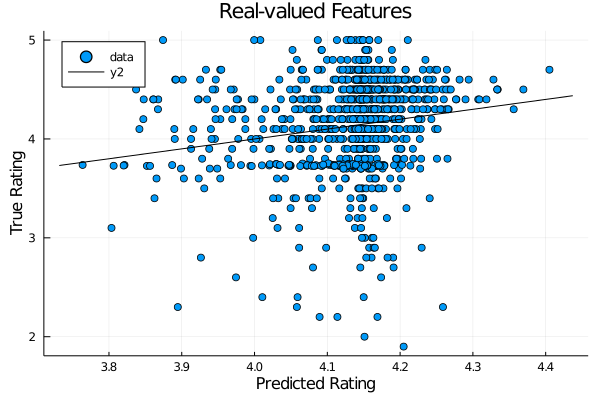

In [202]:
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued Features")

# (C) One-Hot Encoding

In [37]:
# Create one hot encoding for category-type columns 

cat_labels = [
    :Category,
    :Type,
    :ContentRating
]

#Sets of all categories in a particular column
cats_sets = [unique(train_x[:, label]) for label in cat_labels]

3-element Array{Array{String,1},1}:
 ["FAMILY", "PARENTING", "FINANCE", "BUSINESS", "MEDICAL", "TOOLS", "HEALTH_AND_FITNESS", "SHOPPING", "GAME", "PERSONALIZATION"  …  "DATING", "HOUSE_AND_HOME", "VIDEO_PLAYERS", "AUTO_AND_VEHICLES", "BEAUTY", "ART_AND_DESIGN", "COMICS", "EVENTS", "LIBRARIES_AND_DEMO", "WEATHER"]
 ["Free", "Paid"]
 ["Teen", "Everyone", "Everyone 10+", "Mature 17+", "Unrated", "Adults only 18+"]

In [38]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    n = size(column,1) 
    d = size(cats,1) 
    result = zeros(n, d)
    for i = 1:n 
        for j=1:d
            if column[i] == cats[j] 
                result[i, j] = 1
            end 
        end
    end
    return result
end

onehot

In [39]:
category_onehot = onehot(train_x[:, :Category], cats_sets[1])

8671×33 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [40]:
type_onehot = onehot(train_x[:, :Type], cats_sets[2])

8671×2 Array{Float64,2}:
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 ⋮    
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0

In [41]:
content_rating_onehot = onehot(train_x[:, :ContentRating], cats_sets[3])

8671×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0

In [42]:
train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...) 

2168×41 Array{Float64,2}:
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [43]:
train_vals = hcat(train_cat_vals, train_vals_real)
test_vals = hcat(test_cat_vals, test_vals_real)

w = train_vals \ train_y 

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued + One-hot Features")
png("OneHot")

Train MSE	0.24318131246719876
Test MSE 	0.22147719925918294


# (D) Many-Hot Encoding

In [44]:
print(train_x[1:100, :Genres])

["Entertainment", "Entertainment", "Parenting", "Finance", "Business", "Medical", "Tools", "Health & Fitness", "Shopping", "Shopping", "Casual", "Personalization", "News & Magazines", "Productivity", "Sports", "Lifestyle", "Lifestyle", "Strategy", "Books & Reference", "Food & Drink", "Photography", "Tools", "Tools", "Travel & Local", "Maps & Navigation", "Simulation", "Productivity", "Education", "Strategy", "Photography", "Entertainment;Music & Video", "Books & Reference", "Health & Fitness", "Casual", "Productivity", "Sports", "Social", "Arcade", "Education", "Tools", "Lifestyle", "Racing", "Photography", "Productivity", "Photography", "Productivity", "Productivity", "Education", "Finance", "Lifestyle", "Business", "Finance", "Health & Fitness", "Personalization", "Education;Brain Games", "News & Magazines", "Travel & Local", "Entertainment", "Travel & Local", "Business", "Productivity", "Photography", "Finance", "Personalization", "Personalization", "Finance", "Travel & Local", "New

In [45]:
split_genres(x) = split(x, ";")
example_genres = split_genres(train_x[4, :Genres])

1-element Array{SubString{String},1}:
 "Finance"

In [46]:
genres_train = split_genres.(train_x[:, :Genres])
genres_test = split_genres.(test_x[:, :Genres])

2168-element Array{Array{SubString{String},1},1}:
 ["Business"]
 ["Medical"]
 ["Entertainment"]
 ["Medical"]
 ["Beauty"]
 ["Strategy"]
 ["Lifestyle"]
 ["Education"]
 ["Shopping"]
 ["Medical"]
 ["Education"]
 ["Social"]
 ["Word"]
 ⋮
 ["Productivity"]
 ["Sports"]
 ["Sports"]
 ["Beauty"]
 ["Tools"]
 ["Entertainment"]
 ["Personalization"]
 ["Casual", "Education"]
 ["Medical"]
 ["Video Players & Editors"]
 ["House & Home"]
 ["Health & Fitness"]

In [47]:
genre_types = unique(vcat(genres_train...))

53-element Array{SubString{String},1}:
 "Entertainment"
 "Parenting"
 "Finance"
 "Business"
 "Medical"
 "Tools"
 "Health & Fitness"
 "Shopping"
 "Casual"
 "Personalization"
 "News & Magazines"
 "Productivity"
 "Sports"
 ⋮
 "Beauty"
 "Art & Design"
 "Pretend Play"
 "Comics"
 "Adventure"
 "Word"
 "Creativity"
 "Card"
 "Events"
 "Libraries & Demo"
 "Weather"
 "Music & Audio"

In [48]:
"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column, cats=unique(col))
    n = size(column, 1)
    d = size(cats, 1)
    result = zeros(n, d)
    
    for i = 1:n
        set_of_descriptions = column[i]
        for j = 1:d 
            if cats[j] in set_of_descriptions
                result[i, j] = 1 
            end
        end
    end 
    result
end

manyhot

In [49]:
genre_vals_train = manyhot(genres_train, genre_types)
genre_vals_test = manyhot(genres_test, genre_types)

two = 0 
for i=1:size(genre_vals_train, 1)
    total = sum(genre_vals_train[i, :])
    if total > 1
        two += 1
    end
end
println(two)
println(size(genre_vals_train, 1) - two)
println((size(genre_vals_train, 1) - two)/(two + size(genre_vals_train, 1)))

359
8312
0.9204872646733112


Train MSE	0.24068927483536406
Test MSE 	0.2237325423158893


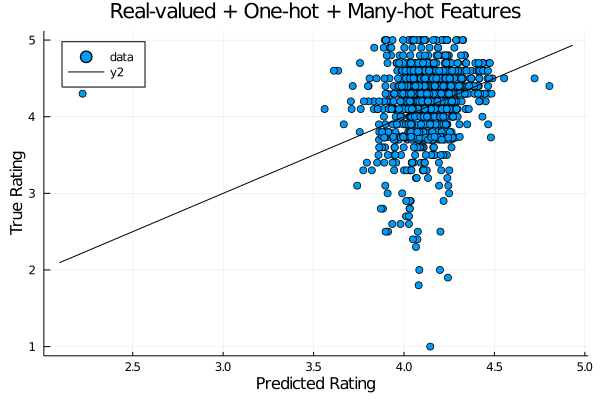

In [50]:
train_vals = hcat(genre_vals_train, train_vals)
test_vals = hcat(genre_vals_test, test_vals)

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued + One-hot + Many-hot Features")

# (E) Data Exploration

### Ratings

In [51]:
println(mean(apps[:, :Rating]))
println(minimum(apps[:, :Rating]))
println(maximum(apps[:, :Rating]))
median(apps[:, :Rating])

4.129523241124758
1.0
5.0


4.2

In [125]:
theme(:sand)

@df apps density(:Rating, xlabel="App Rating", ylabel="Frequency", legend=false)
png("RatingDensity")

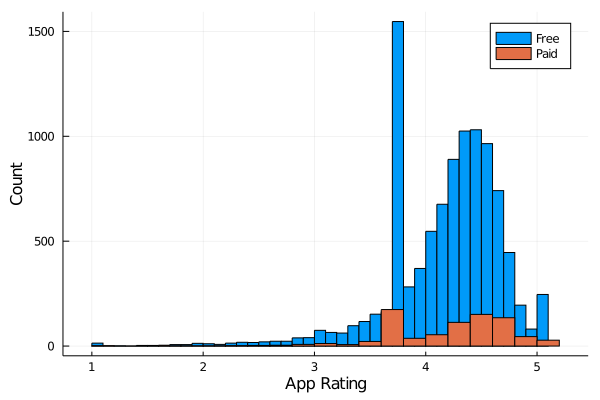

In [53]:
@df apps histogram(:Rating, group=:Type, xlabel="App Rating", ylabel="Count")

### Category

In [54]:
category_count = [] 
for idx=1:size(category_onehot,2)
    push!(category_count, sum(category_onehot[:, idx]))
end 
print(category_count)

Any[1581.0, 47.0, 302.0, 359.0, 376.0, 666.0, 279.0, 211.0, 917.0, 302.0, 235.0, 347.0, 292.0, 307.0, 190.0, 97.0, 268.0, 213.0, 108.0, 242.0, 300.0, 121.0, 121.0, 196.0, 66.0, 135.0, 71.0, 42.0, 51.0, 48.0, 50.0, 63.0, 68.0]

In [127]:
bar(category_count, xticks = (1:33, cats_sets[1]), xrotation=70, margin=10mm, legend=false, xlabel="Categories", ylabel="Count")
plot!(size=(700,600))
png("CategoryCount")


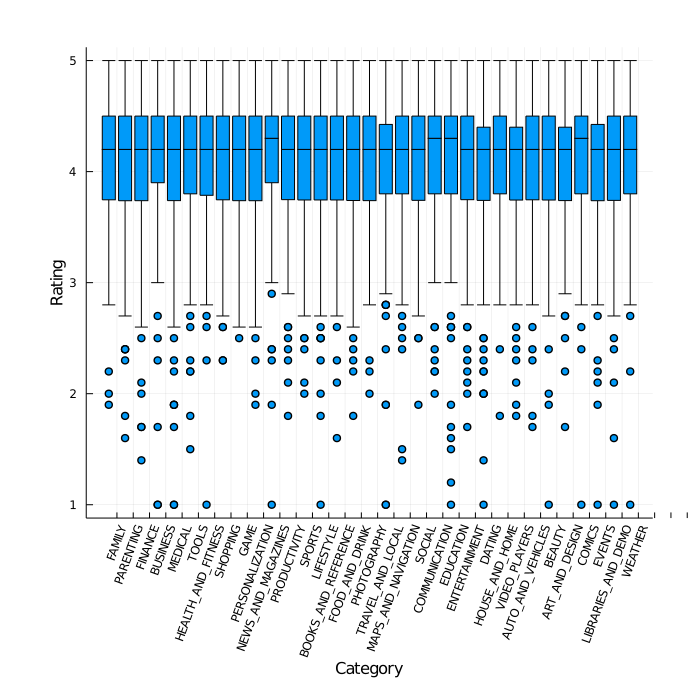

In [56]:

@df apps boxplot(cats_sets[1], :Rating, legend=false, xrotation=70, margin=10mm, xticks = (1:53, cats_sets[1]), 
    xlabel="Category", ylabel="Rating")
plot!(size=(700,700))

### Reviews

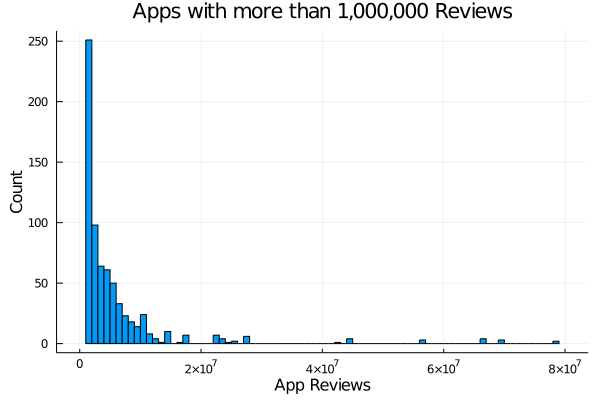

In [57]:
reviews_fl = transform(apps, :Reviews => ByRow(x -> string_to_float(x)) => :Reviews)
reviews_float = filter(row -> (row.Reviews > 1000000), reviews_fl); 
@df reviews_float histogram(:Reviews, xlabel="App Reviews", ylabel="Count", title="Apps with more than 1,000,000 Reviews", legend=false)

In [58]:
println(mean(reviews_fl[:, :Reviews]))
println(minimum(reviews_fl[:, :Reviews]))
println(maximum(reviews_fl[:, :Reviews]))
median(reviews_fl[:, :Reviews])

444193.87332779774
0.0
7.8158306e7


2094.0

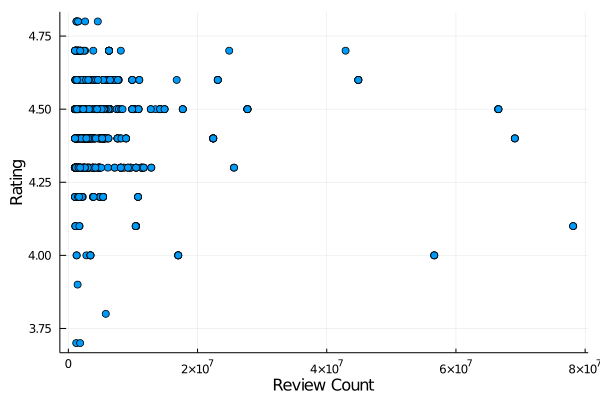

In [59]:
@df reviews_float scatter(:Reviews, :Rating, xlabel="Review Count", ylabel="Rating", legend=false)

### Size

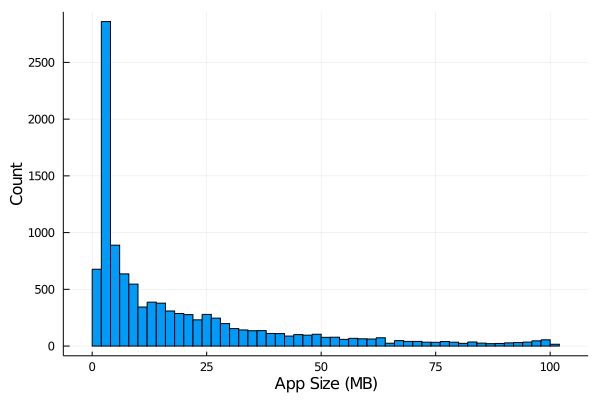

In [60]:
@df apps histogram(:Size, xlabel="App Size (MB)", ylabel="Count", legend=false)

In [61]:
println(mean(apps[:, :Size]))
println(minimum(apps[:, :Size]))
println(maximum(apps[:, :Size]))
median(apps[:, :Size])

18.54372396822271
0.0
100.0


9.2

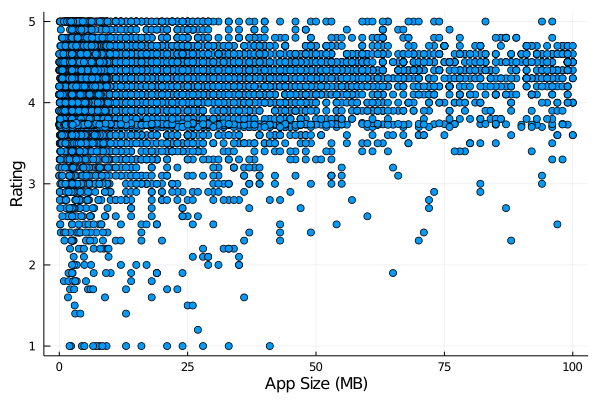

In [62]:
@df apps scatter(:Size, :Rating, xlabel="App Size (MB)", ylabel="Rating", legend=false)

### Type and Installs

In [63]:
type_count = [] 
for idx=1:size(type_onehot,2)
    push!(type_count, sum(type_onehot[:, idx]))
end 
print(type_count)
646/(8025.0+646)


Any[8034.0, 637.0]

0.07450121093299504

In [64]:
8025/(8025.0+646)

0.925498789067005

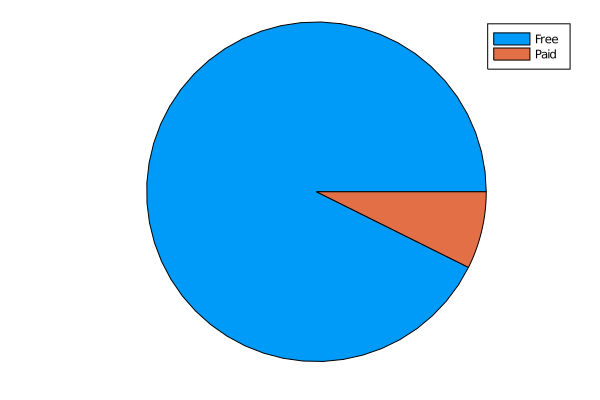

In [65]:
pie(cats_sets[2], type_count)

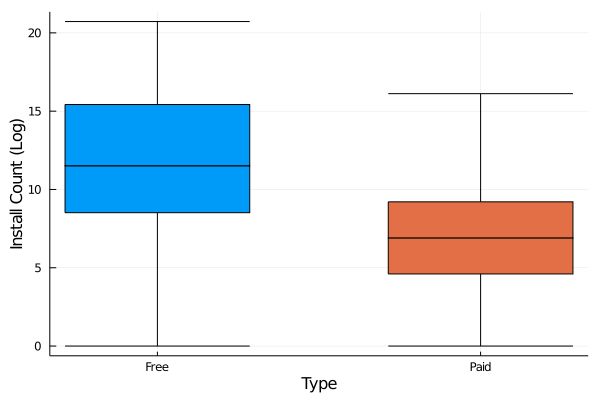

In [66]:
installs_fl = transform(apps, :Installs => ByRow(x -> string_to_float(x)) => :Installs)
installs_float = filter(row -> !(row.Installs in [0]), installs_fl); # log(0) is undefined. 
installs_log = transform(installs_float, :Installs => ByRow(x -> log(x)) => :Installs)
@df installs_log boxplot(:Type, :Installs, group=:Type, legend=false, xlabel="Type", ylabel="Install Count (Log)")

1.5465765613709752e7
0.0
1.0e9


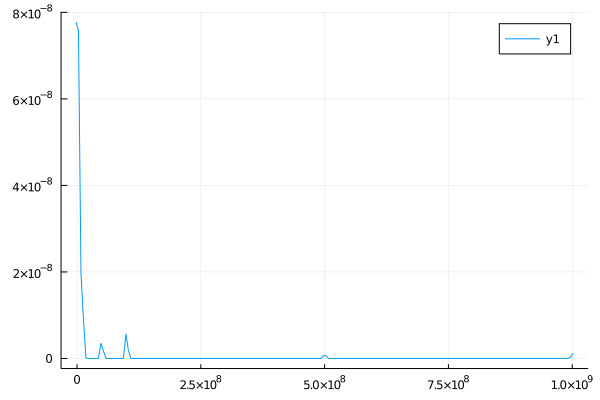

In [67]:
println(mean(installs_fl[:, :Installs]))
println(minimum(installs_fl[:, :Installs]))
println(maximum(installs_fl[:, :Installs]))
median(installs_fl[:, :Installs])

@df installs_fl density(:Installs)

### Price

In [68]:
for i=1:size(apps, 1)
    
    if apps[i, :Type] == "Free"
        if apps[i, :Price] != 0
            println(apps[i, :Price])
        end
    end
    
    if apps[i, :Price] == 0
        if apps[i, :Type] != "Free"
            println(apps[i, :Type])
        end
    end
end

paid_apps = filter(row -> !(row.Type in ["Free"]), apps);
non_zero = filter(row -> !(row.Price in [0]), apps);

println("Count of paid apps: ", size(paid_apps))
println("Count of paid apps: ", size(non_zero))

price_float = Float64[]
for i=1:size(paid_apps, 1)
    price = paid_apps[i, :Price]
    push!(price_float, price)
end

Count of paid apps: (800, 13)
Count of paid apps: (800, 13)


In [69]:
println(minimum(paid_apps[:, :Price]))
println(maximum(paid_apps[:, :Price]))
println(mean(paid_apps[:, :Price]))

0.99
400.0
13.920837500000003


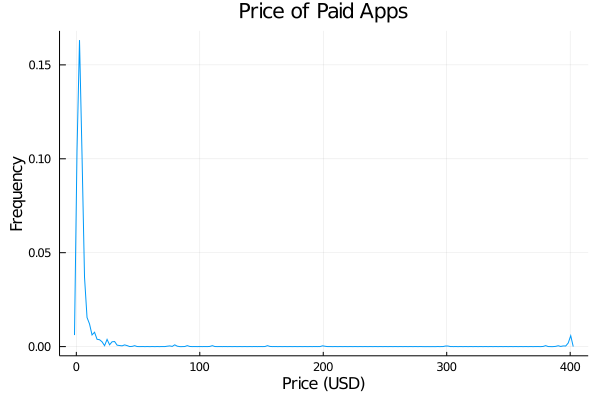

In [70]:
density(price_float, label=false, title="Price of Paid Apps", xlabel="Price (USD)", ylabel="Frequency")

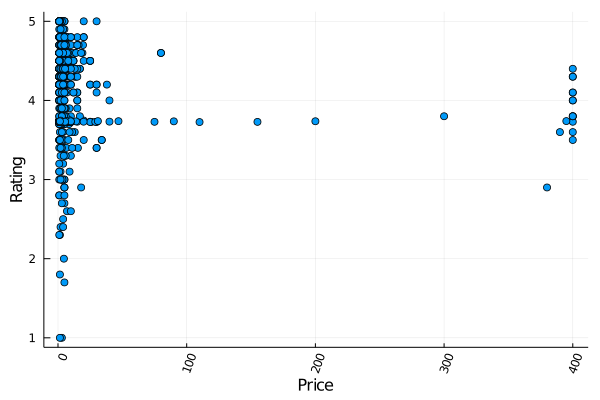

In [71]:
scatter(paid_apps[:, :Price], paid_apps[:, :Rating], xlabel="Price", ylabel="Rating", legend=false, xrotation=70)

### Content Rating

In [128]:
content_count = [] 
for idx=1:size(content_rating_onehot,2)
    push!(content_count, sum(content_rating_onehot[:, idx]))
end 

println(sum(content_count))
print(content_count)
print(content_count./sum(content_count))

8671.0
Any[981.0, 6947.0, 323.0, 417.0, 1.0, 2.0][0.1131357398223965, 0.8011763349094684, 0.03725060546649752, 0.04809133894591166, 0.00011532695190866105, 0.0002306539038173221]

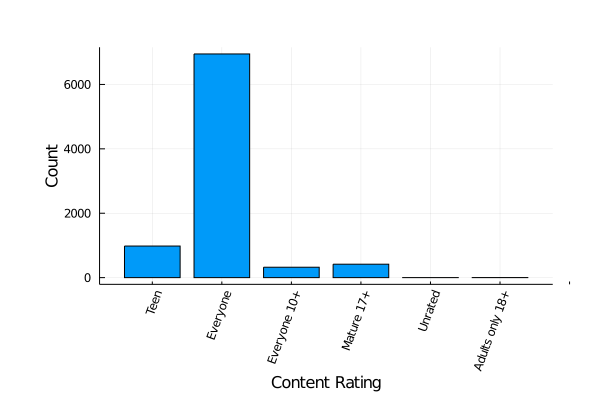

In [73]:
bar(content_count, xticks = (1:33, cats_sets[3]), xrotation=70, margin=10mm, legend=false, xlabel="Content Rating", ylabel="Count")
# plot!(size=(700,600))

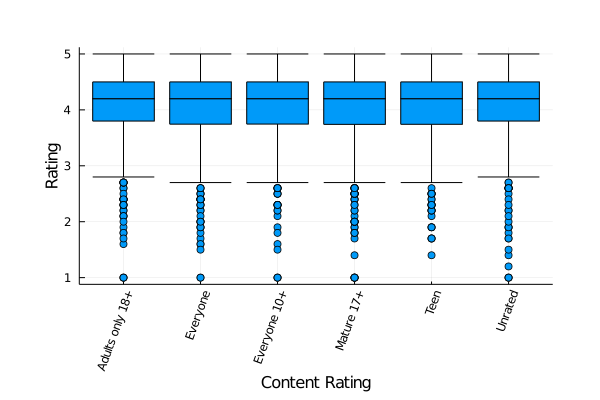

In [74]:
@df apps boxplot(cats_sets[3], :Rating, legend=false, xrotation=70, margin=10mm, 
    xlabel="Content Rating", ylabel="Rating")
# plot!(size=(700,700))

In [75]:
# Correlation between columns? Check for built in function. 
real_vals = transform(apps, :Installs => ByRow(x -> string_to_float(x)) => :Installs);
real_vals = transform(real_vals, :Reviews => ByRow(x -> string_to_float(x)) => :Reviews);
real_vals = transform(real_vals, :Rating => ByRow(x -> real(x)) => :Rating)

10839×13 DataFrame. Omitted printing of 11 columns
│ Row   │ Rating  │ Size    │
│       │ Float64 │ Float64 │
├───────┼─────────┼─────────┤
│ 1     │ 4.3     │ 2.49972 │
│ 2     │ 3.72887 │ 34.0    │
│ 3     │ 3.72835 │ 5.5     │
│ 4     │ 4.2     │ 45.0    │
│ 5     │ 4.4     │ 4.7     │
│ 6     │ 4.4     │ 2.48849 │
│ 7     │ 4.0     │ 1.5     │
│ 8     │ 4.0     │ 23.0    │
│ 9     │ 4.6     │ 11.0    │
│ 10    │ 4.6     │ 2.50276 │
⋮
│ 10829 │ 4.0     │ 43.0    │
│ 10830 │ 4.4     │ 66.0    │
│ 10831 │ 4.4     │ 24.0    │
│ 10832 │ 4.3     │ 0.6     │
│ 10833 │ 3.3     │ 9.0     │
│ 10834 │ 4.2     │ 3.3     │
│ 10835 │ 4.3     │ 44.0    │
│ 10836 │ 5.0     │ 4.6     │
│ 10837 │ 4.5     │ 13.0    │
│ 10838 │ 3.4     │ 77.0    │
│ 10839 │ 3.9     │ 2.50661 │

In [76]:
@df real_vals corrplot([:Rating :Size :Installs :Reviews :Price :LastUpdated], grid=false);

In [77]:
correlation = @df real_vals cor([:Rating :Reviews :Size :Installs :Price :LastUpdated])

6×6 Array{Float64,2}:
  1.0         0.0833684    0.0754824    0.0711273   -0.0224723    0.14278
  0.0833684   1.0          0.0727732    0.643121    -0.00966818   0.0852966
  0.0754824   0.0727732    1.0          0.00593759  -0.0145919    0.153833
  0.0711273   0.643121     0.00593759   1.0         -0.0116906    0.100924
 -0.0224723  -0.00966818  -0.0145919   -0.0116906    1.0         -0.00686084
  0.14278     0.0852966    0.153833     0.100924    -0.00686084   1.0

In [78]:
correlation_labels = correlation
for i=1:6
    for j=1:6
        correlation_labels[i, j] = round(correlation[i, j], digits=4)
    end
end

In [79]:
theme(:sand)
labels = ["Rating", "Reviews", "Size", "Installs", "Price", "LastUpdated"]
heatmap(labels, labels, correlation, yflip=true)
annotate!(vec(tuple.((1:length(labels))'.-0.5, (1:length(labels)).-0.5, string.(correlation_labels), 10)))
png("CorrelationPlot")
# annotate!(correlation)

# (F) Date Data

### Last Updated Column

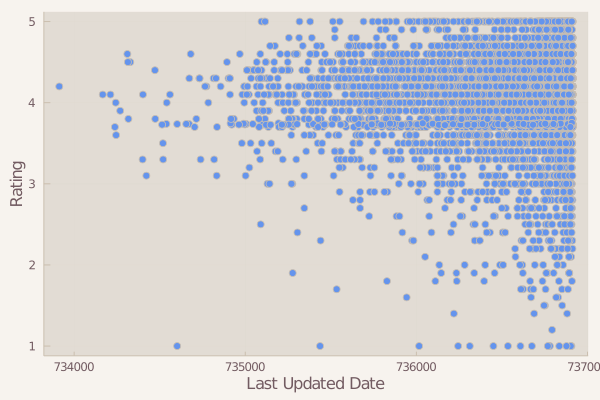

In [80]:
# Plot LastUpdated vs Rating
scatter(apps[:, :LastUpdated], apps[:, :Rating], xlabel="Last Updated Date", ylabel="Rating", legend=false)

In [81]:
println(Dates.rata2datetime(minimum(apps[:, :LastUpdated])))
println(Dates.rata2datetime(maximum(apps[:, :LastUpdated])))
print(Dates.rata2datetime(median(apps[:, :LastUpdated])))

2010-05-21T00:00:00
2018-08-08T00:00:00
2018-05-24T00:00:00

Train MSE	0.24068927483536412
Test MSE 	0.2237325423158884


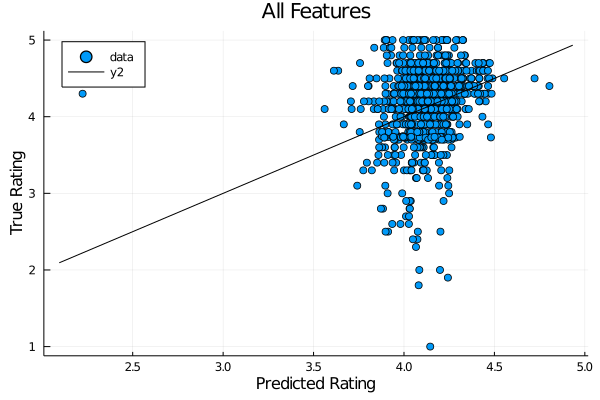

In [82]:
train_vals = hcat(train_x[:, :LastUpdated], train_vals)
test_vals = hcat(test_x[:, :LastUpdated], test_vals)

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "All Features")

### User Reviews

In [83]:
reviews = CSV.read("googleplaystore_user_reviews.csv", pool=false)
names!(reviews, Symbol.(replace.(string.(names(reviews)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(reviews)
for i in 1:5
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

1	App			Number
2	Translated_Review			Float64
3	Sentiment			String
4	Sentiment_Polarity			String
5	Sentiment_Subjectivity			String


In [84]:
reviews

64295×5 DataFrame. Omitted printing of 4 columns
│ Row   │ App                         │
│       │ String                      │
├───────┼─────────────────────────────┤
│ 1     │ 10 Best Foods for You       │
│ 2     │ 10 Best Foods for You       │
│ 3     │ 10 Best Foods for You       │
│ 4     │ 10 Best Foods for You       │
│ 5     │ 10 Best Foods for You       │
│ 6     │ 10 Best Foods for You       │
│ 7     │ 10 Best Foods for You       │
│ 8     │ 10 Best Foods for You       │
│ 9     │ 10 Best Foods for You       │
│ 10    │ 10 Best Foods for You       │
⋮
│ 64285 │ Houzz Interior Design Ideas │
│ 64286 │ Houzz Interior Design Ideas │
│ 64287 │ Houzz Interior Design Ideas │
│ 64288 │ Houzz Interior Design Ideas │
│ 64289 │ Houzz Interior Design Ideas │
│ 64290 │ Houzz Interior Design Ideas │
│ 64291 │ Houzz Interior Design Ideas │
│ 64292 │ Houzz Interior Design Ideas │
│ 64293 │ Houzz Interior Design Ideas │
│ 64294 │ Houzz Interior Design Ideas │
│ 64295 │ Houzz Interior Design Ideas │

In [85]:
# reviews = filter(row -> !(row.Translated_Review ), reviews)

In [86]:
print("Number of apps with reviews: ", length(unique(reviews[:, :App])))

Number of apps with reviews: 1074

In [87]:
unique_apps = unique(apps[:, :App]);

In [88]:
unique_revs = unique(reviews[:, :App]);

In [89]:
match_reviews = filter(row -> (row.App in unique_apps), reviews)
print(length(unique(match_reviews[:, :App])))

1020

# (G) Feature Modeling

Let's compare predict rating with each feature individually to see which has the lowest error and explore that feature more closely.

### Category

In [90]:
train_vals_cat = hcat(onehot(train_x[:, :Category], cats_sets[1]), ones(ntrain, 1))
test_vals_cat = hcat(onehot(test_x[:, :Category], cats_sets[1]), ones(ntest, 1))

w = train_vals_cat \ train_y

train_pred_cat = [sum(w.*train_vals_cat[i, :]) for i=1:size(train_vals_cat, 1)] 
test_pred_cat = [sum(w.*test_vals_cat[i, :]) for i=1:size(test_vals_cat, 1)] 

train_MSE_cat = MSE(train_y, train_pred_cat)
test_MSE_cat = MSE(test_y, test_pred_cat)
    
println("Train MSE\t", train_MSE_cat)
println("Test MSE \t", test_MSE_cat)

Train MSE	0.25100657183653935
Test MSE 	0.22636440070922753


### Reviews

In [91]:
train_vals_rev = hcat(train_vals_real[:, 1], ones(ntrain, 1))
test_vals_rev = hcat(test_vals_real[:, 1], ones(ntest, 1))

w = train_vals_rev \ train_y

train_pred_rev = [sum(w.*train_vals_rev[i, :]) for i=1:size(train_vals_rev, 1)] 
test_pred_rev = [sum(w.*test_vals_rev[i, :]) for i=1:size(test_vals_rev, 1)] 

train_MSE_rev = MSE(train_y, train_pred_rev)
test_MSE_rev = MSE(test_y, test_pred_rev)
    
println("Train MSE\t", train_MSE_rev)
println("Test MSE \t", test_MSE_rev)

Train MSE	0.25791967856753906
Test MSE 	0.22957458756461657


### Size

In [92]:
train_vals_size = hcat(train_vals_real[:, 2], ones(ntrain, 1))
test_vals_size = hcat(test_vals_real[:, 2], ones(ntest, 1))

w = train_vals_size \ train_y

train_pred_size = [sum(w.*train_vals_size[i, :]) for i=1:size(train_vals_size, 1)] 
test_pred_size = [sum(w.*test_vals_size[i, :]) for i=1:size(test_vals_size, 1)] 

train_MSE_size = MSE(train_y, train_pred_size)
test_MSE_size = MSE(test_y, test_pred_size)
    
println("Train MSE\t", train_MSE_size)
println("Test MSE \t", test_MSE_size)

Train MSE	0.25854384157325655
Test MSE 	0.22942571181300755


### Installs

In [93]:
train_vals_installs = hcat(train_vals_real[:, 3], ones(ntrain, 1))
test_vals_installs = hcat(test_vals_real[:, 3], ones(ntest, 1))

w = train_vals_installs \ train_y

train_pred_installs = [sum(w.*train_vals_installs[i, :]) for i=1:size(train_vals_installs, 1)] 
test_pred_installs = [sum(w.*test_vals_installs[i, :]) for i=1:size(test_vals_installs, 1)] 

train_MSE_installs = MSE(train_y, train_pred_installs)
test_MSE_installs = MSE(test_y, test_pred_installs)
    
println("Train MSE\t", train_MSE_installs)
println("Test MSE \t", test_MSE_installs)

Train MSE	0.25856069043298147
Test MSE 	0.22854489469966446


### Type

In [94]:
train_vals_type = hcat(onehot(train_x[:, :Type], cats_sets[2]), ones(ntrain, 1))
test_vals_type = hcat(onehot(test_x[:, :Type], cats_sets[2]), ones(ntest, 1))

w = train_vals_type \ train_y

train_pred_type = [sum(w.*train_vals_type[i, :]) for i=1:size(train_vals_type, 1)] 
test_pred_type = [sum(w.*test_vals_type[i, :]) for i=1:size(test_vals_type, 1)] 

train_MSE_type = MSE(train_y, train_pred_type)
test_MSE_type = MSE(test_y, test_pred_type)
    
println("Train MSE\t", train_MSE_type)
println("Test MSE \t", test_MSE_type)

Train MSE	0.2598167625623953
Test MSE 	0.2303534643832012


### Price

In [174]:
train_vals = hcat(train_x[:, :Price], ones(ntrain, 1))
test_vals = hcat(test_x[:, :Price], ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.2597697359487661
Test MSE 	0.2303002908619926


### Content Rating

In [96]:
train_vals_cr = hcat(onehot(train_x[:, :ContentRating], cats_sets[3]), ones(ntrain, 1))
test_vals_cr = hcat(onehot(test_x[:, :ContentRating], cats_sets[3]), ones(ntest, 1))

w = train_vals_cr \ train_y

train_pred_cr = [sum(w.*train_vals_cr[i, :]) for i=1:size(train_vals_cr, 1)] 
test_pred_cr = [sum(w.*test_vals_cr[i, :]) for i=1:size(test_vals_cr, 1)] 

train_MSE_cr = MSE(train_y, train_pred_cr)
test_MSE_cr = MSE(test_y, test_pred_cr)
    
println("Train MSE\t", train_MSE_cr)
println("Test MSE \t", test_MSE_cr)

Train MSE	0.2589179153329239
Test MSE 	0.22990836135117418


### Genres

In [97]:
train_vals_genre = hcat(genre_vals_train, ones(ntrain, 1))
test_vals_genre = hcat(genre_vals_test, ones(ntest, 1))

w = train_vals_genre \ train_y

train_pred_genre = [sum(w.*train_vals_genre[i, :]) for i=1:size(train_vals_genre, 1)] 
test_pred_genre = [sum(w.*test_vals_genre[i, :]) for i=1:size(test_vals_genre, 1)] 

train_MSE_genre = MSE(train_y, train_pred_genre)
test_MSE_genre = MSE(test_y, test_pred_genre)
    
println("Train MSE\t", train_MSE_genre)
println("Test MSE \t", test_MSE_genre)

Train MSE	0.24966200102665542
Test MSE 	0.22487366031214973


### Last Updated

Train MSE	0.2544293528955028
Test MSE 	0.22645401477252425


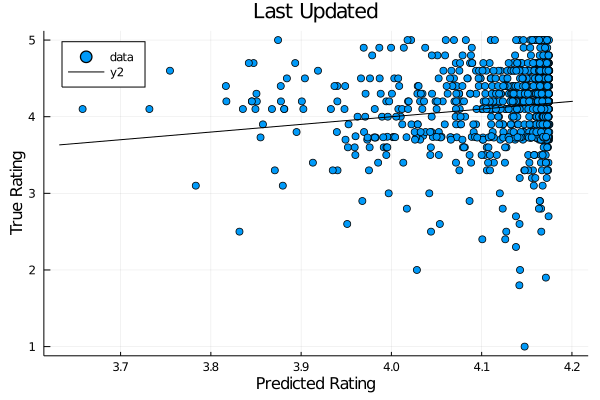

In [98]:
train_vals_update = hcat(train_x[:, :LastUpdated], ones(ntrain, 1))
test_vals_update = hcat(test_x[:, :LastUpdated], ones(ntest, 1))

w = train_vals_update \ train_y

train_pred_update = [sum(w.*train_vals_update[i, :]) for i=1:size(train_vals_update, 1)] 
test_pred_update = [sum(w.*test_vals_update[i, :]) for i=1:size(test_vals_update, 1)] 

train_MSE_update = MSE(train_y, train_pred_update)
test_MSE_update = MSE(test_y, test_pred_update)
    
println("Train MSE\t", train_MSE_update)
println("Test MSE \t", test_MSE_update)

plot_pred_true(test_pred_update, test_y, "Last Updated")

# (H) Regularized Linear Models

### L1 Loss

Train MSE	0.264941956420796
Test MSE 	0.23330887357637048


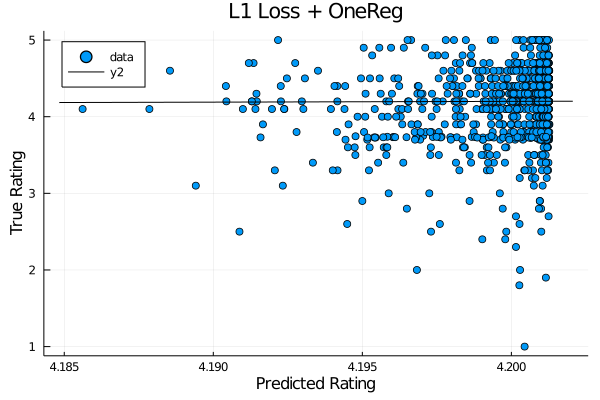

In [99]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg = λ * OneReg()
w_l1 = proxgrad(loss, reg, train_vals_update, train_y, maxiters=100)

train_pred = train_vals_update*w_l1
test_pred = test_vals_update*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + OneReg")

In [100]:
println("Min predicted rating: ", minimum(test_pred))
println("Max predicted rating: ", maximum(test_pred))

Min predicted rating: 4.185615930717564
Max predicted rating: 4.20127706362284


**Note:** Our predicted ratings are in the range 0-9, we need to limit this to 1-5. Let's try other regularizers to see if that helps.

Train MSE	16.408639529357067
Test MSE 	16.522746393087456


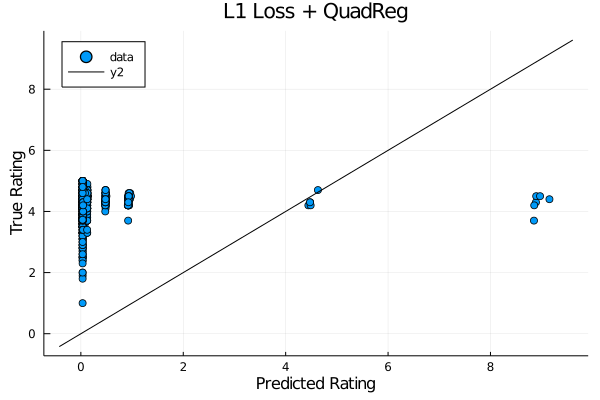

In [101]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg =  λ * QuadReg()
w_l1 = proxgrad(loss, reg, train_vals, train_y, maxiters=100) 

train_pred = train_vals*w_l1
test_pred = test_vals*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + QuadReg")

**Note:** Let's experiment using features individually and some combinations.

In [102]:
features_train = [train_vals_cat, train_vals_rev, train_vals_size, train_vals_installs, train_vals_type, train_vals_cr, 
    train_vals_genre, train_vals_update]

features_test = [test_vals_cat, test_vals_rev, test_vals_size, test_vals_installs, test_vals_type, test_vals_cr, 
    test_vals_genre, test_vals_update]

features = ["Category", "Reviews", "Size", "Installs", "Type", "ContentRating", "Genre", "LastUpdate"]

for i=1:length(features_train)
    
    println(features[i])
    
    loss = 1/ntrain * L1Loss()
    λ = 0.1
    reg = λ * OneReg()
    w_l1 = proxgrad(loss, reg, features_train[i], train_y, maxiters=100)

    train_pred = features_train[i]*w_l1
    test_pred = features_test[i]*w_l1

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)
    
    println("Min predicted rating: ", minimum(test_pred))
    println("Max predicted rating: ", maximum(test_pred))

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)
    print("\n")
       
end


Category
Train MSE	0.2603032606103015
Test MSE 	0.2300468882722306
Min predicted rating: 4.143793608003702
Max predicted rating: 4.157649780878802

Reviews
Train MSE	17.6036048873697
Test MSE 	18.05752974405792
Min predicted rating: 1.9833387837823197e-11
Max predicted rating: 41.39297888068571

Size
Train MSE	16.68497170297451
Test MSE 	16.79849396546885
Min predicted rating: 1.0585073856785882e-14
Max predicted rating: 8.800000000001935

Installs
Train MSE	7.937027434221922
Test MSE 	7.917873307946536
Min predicted rating: 0.47238460096874807
Max predicted rating: 9.498320720559889

Type
Train MSE	0.44117522192940506
Test MSE 	0.41456275641406565
Min predicted rating: 2.611861651592242
Max predicted rating: 4.1925960096874855

ContentRating
Train MSE	0.26542345437306103
Test MSE 	0.2333589993674588
Min predicted rating: 4.109345814840609
Max predicted rating: 4.195479183485199

Genre
Train MSE	0.26529720137656376
Test MSE 	0.23362484308200385
Min predicted rating: 4.2
Max predicted r

Min predicted rating: 4.18475118625719
Max predicted rating: 5.8489287939059915
Train MSE	0.26451769019090454
Test MSE 	0.2345855148597227


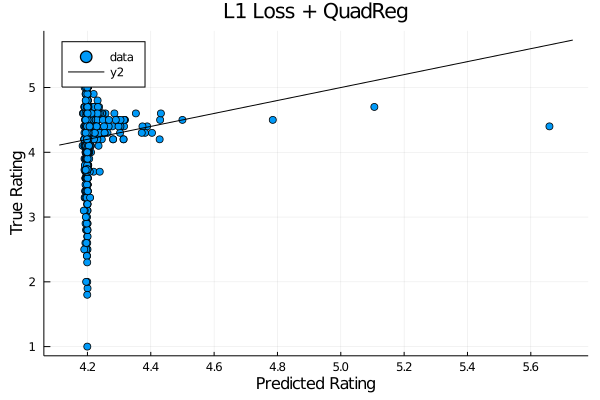

In [103]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg =  λ * QuadReg()

train_vals_rev_update = hcat(train_vals_rev, train_vals_update)
test_vals_rev_update = hcat(test_vals_rev, test_vals_update)

w_l1 = proxgrad(loss, reg, train_vals_rev_update, train_y, maxiters=100) 

train_pred = train_vals_rev_update*w_l1
test_pred = test_vals_rev_update*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Min predicted rating: ", minimum(test_pred))
println("Max predicted rating: ", maximum(test_pred))

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + QuadReg")

# (I) Other Sklearn Models

In [104]:
Pkg.add("ScikitLearn")
using ScikitLearn
@sk_import linear_model: (Ridge, Lasso, ElasticNet)
@sk_import metrics: mean_absolute_error
@sk_import svm: SVR
@sk_import ensemble: RandomForestRegressor
@sk_import neural_network: MLPRegressor
@sk_import tree: (plot_tree, DecisionTreeRegressor)
@sk_import feature_selection: (SelectFromModel, VarianceThreshold)

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


PyObject <class 'sklearn.feature_selection._variance_threshold.VarianceThreshold'>

Train MSE	0.24070186104941424
Test MSE 	0.22002779824984334

Train MAE	0.3629272280865354
Test MAE 	0.35204702900512946


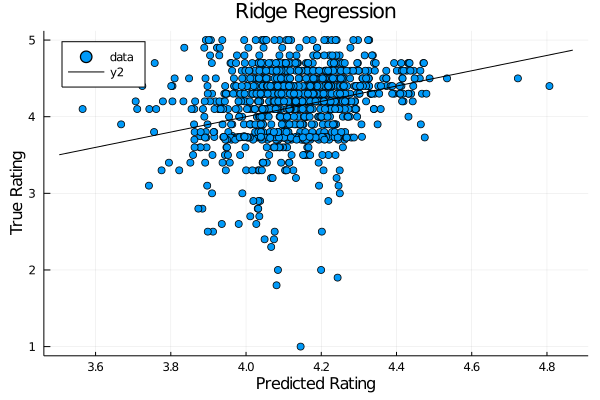

In [105]:
ridge = Ridge()
ridge.fit(train_vals, train_y)

train_pred = ridge.predict(train_vals);
test_pred = ridge.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
  
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Ridge Regression")

Train MSE	0.2528917789649018
Test MSE 	0.2258801780794727

Train MAE	0.37592707603173015
Test MAE 	0.36038831555348666


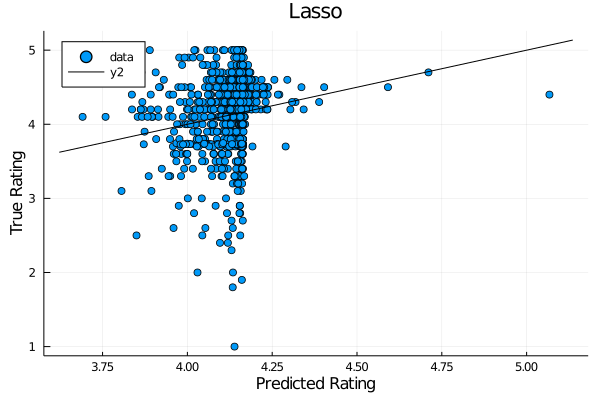

In [106]:
lasso = Lasso()
lasso.fit(train_vals, train_y)

train_pred = lasso.predict(train_vals);
test_pred = lasso.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Lasso")

Train MSE	0.25285231574406763
Test MSE 	0.22585294247441465

Train MAE	0.375806289344965
Test MAE 	0.36030458884684896


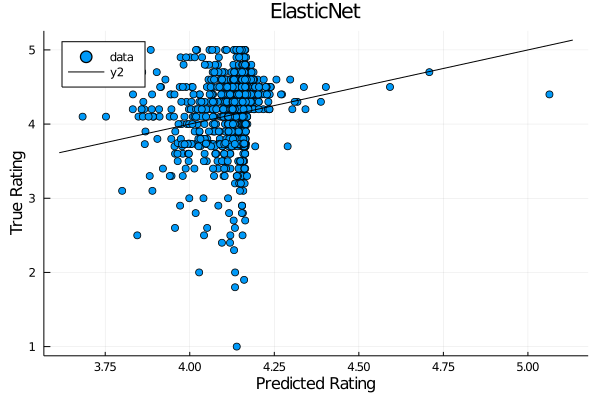

In [107]:
en = ElasticNet()
en.fit(train_vals, train_y)

train_pred = en.predict(train_vals);
test_pred = en.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "ElasticNet")

In [108]:
kernels = ["rbf"]

for i=1:length(kernels)

    println("Type of kernel: ", kernels[i])
    svrModel = SVR(kernel=kernels[i])
    svrModel.fit(train_vals, train_y)

    train_pred = svrModel.predict(train_vals);
    test_pred = svrModel.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

    train_MAE = mean_absolute_error(train_y, train_pred)
    test_MAE = mean_absolute_error(test_y, test_pred)

    print("\n")
    println("Train MAE\t", train_MAE)
    println("Test MAE \t", test_MAE)

    plot_pred_true(test_pred, test_y, "Support Vector Machine")
    
end

Type of kernel: rbf
Train MSE	0.2464266022932856
Test MSE 	0.21834694288008435

Train MAE	0.3610008937576341
Test MAE 	0.3446235128808741


Train MSE	3.416962977538467e-8
Test MSE 	0.34854737261642027

Train MAE	7.85578994678332e-6
Test MAE 	0.3613023947135909


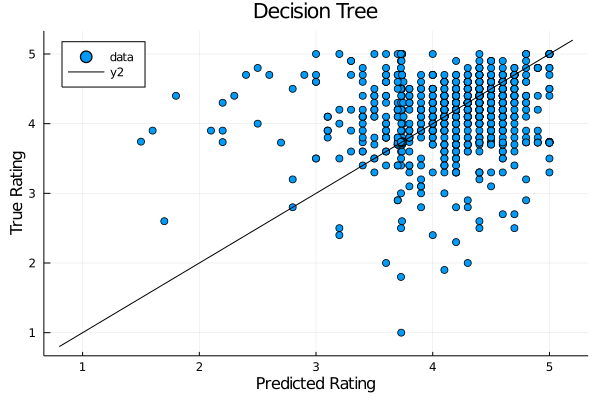

In [109]:
dt = DecisionTreeRegressor()
dt.fit(train_vals, train_y)

train_pred = dt.predict(train_vals);
test_pred = dt.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Decision Tree")

In [110]:
for i=1:10
    
    println("Max depth: ", i)
    dt = DecisionTreeRegressor(max_depth=i, random_state=1)
    dt.fit(train_vals, train_y)

    train_pred = dt.predict(train_vals);
    test_pred = dt.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)
    print("\n")

end

Max depth: 1
Train MSE	0.23564985515510864
Test MSE 	0.2128405288423783

Max depth: 2
Train MSE	0.22791558996426642
Test MSE 	0.2072115518598344

Max depth: 3
Train MSE	0.22443761290566805
Test MSE 	0.20582595532677192

Max depth: 4
Train MSE	0.22022122182226705
Test MSE 	0.20169304795668533

Max depth: 5
Train MSE	0.21524195670313143
Test MSE 	0.20130428050640878

Max depth: 6
Train MSE	0.20918787524347968
Test MSE 	0.20101636785625274

Max depth: 7
Train MSE	0.20142369279213673
Test MSE 	0.20752254174614684

Max depth: 8
Train MSE	0.19235634573338875
Test MSE 	0.2093940434240111

Max depth: 9
Train MSE	0.18237172632249324
Test MSE 	0.22045663827010917

Max depth: 10
Train MSE	0.17074442089261468
Test MSE 	0.22185065542590748



In [155]:
dt = DecisionTreeRegressor(max_depth=7)
@time begin
dt.fit(train_vals, train_y)
end

train_pred = dt.predict(train_vals);
test_pred = dt.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Decision Tree Max-Depth=7")
png("DecisionTree")
println(minimum(test_pred))
println(maximum(test_pred))
println(sizeof(train_vals))

  0.035318 seconds (17 allocations: 976 bytes)
Train MSE	0.20142369279213673
Test MSE 	0.2075813517092465

2.766666666666667
5.0
7006168


In [156]:
print((dt.feature_importances_))

[0.047100304662865286, 0.0037946483782294402, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0070433918617403895, 0.0, 0.0037694827878046824, 0.0, 0.0, 0.0, 0.0, 1.0476645109005309e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032304156255576574, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011620548067898728, 0.0, 0.0, 0.0, 0.0, 0.0020034968769824463, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0030014242225139616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007916530074779443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008338989720683018, 0.0, 0.010322288979780249, 0.009097781872831256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0011611065339497306, 0.0010532791712074873, 0.0, 0.0, 0.0011419520222633005, 7.163342256747547e-7, 0.0, 0.0, 0.00048577044249832206, 0.0, 0.0, 0.009158046496152835, 0.0, 0.0008690896047699472, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007349599332962371, 0.0, 0.0, 0.006422871033928119, 0.0012570351650088138, 0.0, 0.0, 0.0, 0.6172617826940363, 0.13204192873428322, 0.04279177022218836, 0.030818494061830824, 0.0018724667244982372, 0.0]

In [157]:
nonzero = 0
for i = 1:size(dt.feature_importances_, 1)
    if dt.feature_importances_[i] != 0
        nonzero += 1 
    end
end

print(nonzero)

28

In [158]:
println(maximum(dt.feature_importances_))
println(minimum(dt.feature_importances_))
println(mean(dt.feature_importances_))

0.6172617826940363
0.0
0.0099009900990099


In [159]:
sfm = SelectFromModel(dt, threshold=0.01)
sfm.fit(train_vals, train_y)
train_transformed = sfm.transform(train_vals) 
test_transformed = sfm.transform(test_vals)

println("Shape of the dataset ", size(train_transformed))

@time begin
dt.fit(train_transformed, train_y)
end

train_pred = dt.predict(train_transformed);
test_pred = dt.predict(test_transformed);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Reduced Decision Tree Max-Depth=7")
png("DecisionTreeTransformed")

println(minimum(test_pred))
println(maximum(test_pred))
println(sizeof(train_transformed))

Shape of the dataset (8671, 8)
  0.013770 seconds (17 allocations: 976 bytes)
Train MSE	0.20107595517213436
Test MSE 	0.2022089310438944

2.766666666666667
5.0
554944


Train MSE	0.22166890864407898
Test MSE 	0.2048795243295547

Train MAE	0.3204880163862625
Test MAE 	0.3131739835896329


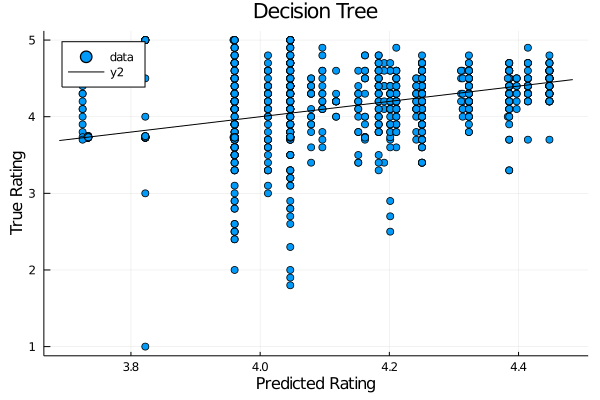

In [154]:
train_vals_update_rev = hcat(train_vals_update, train_vals_rev)
test_vals_update_rev = hcat(test_vals_update, test_vals_rev)

dt = DecisionTreeRegressor(max_depth=5)
dt.fit(train_vals_update_rev, train_y)

train_pred = dt.predict(train_vals_update_rev);
test_pred = dt.predict(test_vals_update_rev);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Decision Tree")

Train MSE	0.0283731041211102
Test MSE 	0.1876594942507751

Train MAE	0.10704311488897045
Test MAE 	0.28117738228767497


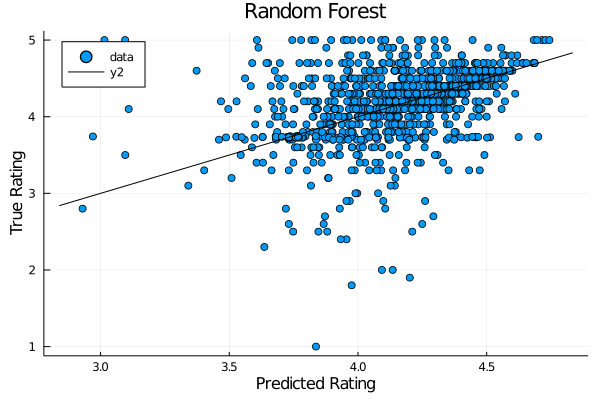

In [160]:
rf = RandomForestRegressor()
rf.fit(train_vals, train_y)

train_pred = rf.predict(train_vals);
test_pred = rf.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Random Forest")

**Note:** Random Forest Regression has the lowest training error thus far, but there is overfitting occuring. Can we reduce the number of features? 

In [117]:
features_train = [train_vals_cat, train_vals_rev, train_vals_size, train_vals_installs, train_vals_type, train_vals_cr, 
    train_vals_genre, train_vals_update]

features_test = [test_vals_cat, test_vals_rev, test_vals_size, test_vals_installs, test_vals_type, test_vals_cr, 
    test_vals_genre, test_vals_update]

features = ["Category", "Reviews", "Size", "Installs", "Type", "ContentRating", "Genre", "LastUpdate"]

for i=1:length(features_train)
    
    println(features[i])
    
    rf = RandomForestRegressor()
    rf.fit(features_train[i], train_y)
    
    train_pred = rf.predict(features_train[i]);
    test_pred = rf.predict(features_test[i]);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)
    print("\n")
       
end


Category
Train MSE	0.2510197536853502
Test MSE 	0.2264768009607501

Reviews
Train MSE	0.1564186323943693
Test MSE 	0.2397752987730249

Size
Train MSE	0.23842398863938985
Test MSE 	0.2146914032371176

Installs
Train MSE	0.23201317405127372
Test MSE 	0.2360690608818156

Type
Train MSE	0.25981255765274525
Test MSE 	0.23026411571889738

ContentRating
Train MSE	0.25891839673490474
Test MSE 	0.22990236871515596

Genre
Train MSE	0.24856081860982185
Test MSE 	0.22478680897620282

LastUpdate
Train MSE	0.20765871232364577
Test MSE 	0.2641755377417909



**Note:** Overfitting still occurs even when reducing feature count. Let's try early stopping, i.e. changing the max depth, rather than reaching pure leaves.

In [161]:
for i=1:10
    
    println("Max depth: ", i)
    rf = RandomForestRegressor(max_depth=i, random_state=1)
    rf.fit(train_vals, train_y)

    train_pred = rf.predict(train_vals);
    test_pred = rf.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)

    print("\n")

#     plot_pred_true(test_pred, test_y, "Random Forest")
end

Max depth: 1
Train MSE	0.2339082667165757
Test MSE 	0.211493245579464

Max depth: 2
Train MSE	0.2266678701387393
Test MSE 	0.20592864908772734

Max depth: 3
Train MSE	0.2205372780526659
Test MSE 	0.20141735736299365

Max depth: 4
Train MSE	0.2143049867797555
Test MSE 	0.19757281170244317

Max depth: 5
Train MSE	0.2068610493491128
Test MSE 	0.19470091048237123

Max depth: 6
Train MSE	0.19784307629799486
Test MSE 	0.19249664318606433

Max depth: 7
Train MSE	0.1876427825338728
Test MSE 	0.1905624106164262

Max depth: 8
Train MSE	0.17600944405009913
Test MSE 	0.18945581817640575

Max depth: 9
Train MSE	0.1636646469272038
Test MSE 	0.18798427447214278

Max depth: 10
Train MSE	0.15063992295075007
Test MSE 	0.18715828324787676



**Conclusion:** Max depth of 5 performs best

In [163]:
rf = RandomForestRegressor(max_depth=8, random_state=1)
rf.fit(train_vals, train_y)

train_pred = rf.predict(train_vals);
test_pred = rf.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

plot_pred_true(test_pred, test_y, "Random Forest Max Depth=8")
png("RandomForest")

In [171]:
println(maximum(test_pred))
println(minimum(test_pred))
println(mean(test_pred))

4.7035825076984885
3.536047598455277
4.131234529054749


In [164]:
println(maximum(rf.feature_importances_))
println(minimum(rf.feature_importances_))
println(mean(rf.feature_importances_))

0.5183346209072173
0.0
0.009900990099009903


In [165]:
print(rf.feature_importances_)

[0.05773542579104858, 0.005415443510202553, 0.0006961089560160729, 0.004337735171045671, 0.001124295917611734, 0.002668325914486852, 0.006302938089289368, 0.006169780357408281, 0.0006271954073570369, 0.0037873652189254372, 0.0011078165204234684, 0.0006702904232136842, 0.000784287380893677, 0.001652421066125369, 0.0034625743063825894, 0.001372940494030185, 0.0007078726293678778, 0.0007092129519273343, 0.001035492214345237, 0.001096121110631978, 0.002458333315240114, 0.0013145177181823843, 0.023733511580186602, 6.553239415181384e-5, 0.0008831035304273672, 0.0010764109337809105, 0.00015866796507469383, 9.059936917340405e-5, 0.0014367751338933655, 6.637252772402945e-5, 0.00047774930788089165, 0.004698950783015365, 0.00021738449166834383, 2.518252696088215e-5, 0.0006191769018861078, 0.0002810278974258228, 0.001565386930842735, 0.0021571160881817112, 0.00032216949862005163, 0.00030676003025348754, 0.0007852554395016587, 0.00012530555423107486, 0.0, 0.0001543852169179065, 0.000144009324507843

In [170]:
sfm = SelectFromModel(rf, threshold=0.001)
sfm.fit(train_vals, train_y)
train_transformed = sfm.transform(train_vals) 
test_transformed = sfm.transform(test_vals)

println("Shape of the dataset ", size(train_transformed))

@time begin
rf.fit(train_transformed, train_y)
end

train_pred = rf.predict(train_transformed);
test_pred = rf.predict(test_transformed);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Reduced Random Forest Max-Depth=5")
# png("DecisionTreeTransformed")

println(minimum(test_pred))
println(maximum(test_pred))
println(sizeof(train_transformed))

Shape of the dataset (8671, 53)
  1.740013 seconds (17 allocations: 976 bytes)
Train MSE	0.17563319235117072
Test MSE 	0.18945897293293695

3.536047598455277
4.7035825076984885
3676504
